<a href="https://colab.research.google.com/github/aepstar/Economic-Mapping/blob/main/Multivariate_Multi_step_LSTM_Manggarai_v0_6_5_9999.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pemodelan prediksi ketinggian muka air di Katulampa, Depok, KBR2, KBR4 dan Manggarai.

Data training dimulai dari tanggal 2022-08-01 00:00:00 sampai dengan 2022-12-31 23:59:00. Data testing dimulai dari 2023-01-01 00:00:00 sampai 2023-03-28 00:00:00.

Pembuatan model dengan parameter LSTM(128), data historis selama 7 hari (7x24 jam) untuk memprediksi 6 jam ke depan.

Scaler menggunakan StandardScaler()

In [ ]:
!python --version
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)


Python 3.10.11
2.12.0
2.12.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# multivariate multi-step data preparation
import pandas as pd
from numpy import array, hstack, delete, squeeze
from numpy.random import seed
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


import matplotlib.pyplot as plt
import math

%matplotlib inline


In [ ]:
os.listdir("drive/Shareddrives")

['CRM',
 'JSC Pengendalian Banjir DKI',
 'Manticore Indonesia',
 'Multimedia Starcore',
 'Outing Starcore',
 'SAB Wyeth',
 'SAS HACKATHON 2023',
 'SCADS',
 'Skystar Omnisight',
 'Starcore Event Organizer',
 'StarCore Learning Center',
 'Vivi Program']

In [ ]:
tma = pd.read_csv("drive/Shareddrives/JSC Pengendalian Banjir DKI/Data/dsda_rupom_tma_wide.csv", sep = ",")
tma = tma.drop(columns=['BDR5'])

In [ ]:
tma.head()

tanggal  Katulampa  Depok  Manggarai        KBR2         KBR4
0  2022-08-01 00:00:00       18.0   77.0      585.0  913.128078  1132.861352
1  2022-08-01 01:00:00       18.0   77.0      584.0  912.531145  1132.817396
2  2022-08-01 02:00:00       18.0   76.0      584.0  913.884112  1132.781257
3  2022-08-01 03:00:00       18.0   76.0      583.0  912.527483  1132.764147
4  2022-08-01 04:00:00       19.0   77.0      583.0  911.968800  1132.749544

In [ ]:
tma[tma['Manggarai'].isna()]

Empty DataFrame
Columns: [tanggal, Katulampa, Depok, Manggarai, KBR2, KBR4]
Index: []

In [ ]:
tma['tanggal'] = pd.to_datetime(tma['tanggal'])
tma.head()

tanggal  Katulampa  Depok  Manggarai        KBR2         KBR4
0 2022-08-01 00:00:00       18.0   77.0      585.0  913.128078  1132.861352
1 2022-08-01 01:00:00       18.0   77.0      584.0  912.531145  1132.817396
2 2022-08-01 02:00:00       18.0   76.0      584.0  913.884112  1132.781257
3 2022-08-01 03:00:00       18.0   76.0      583.0  912.527483  1132.764147
4 2022-08-01 04:00:00       19.0   77.0      583.0  911.968800  1132.749544

In [ ]:
print(tma.tanggal.min(), tma.tanggal.max())

2022-08-01 00:00:00 2023-03-28 00:00:00


In [ ]:
# Data untukk training
tma_train = tma.loc[(tma['tanggal'] >= '2022-08-01 00:00:00')]
tma_train = tma_train.loc[(tma_train['tanggal'] <= '2022-12-31 23:59:00')]
tma_train = tma_train.loc[(tma_train.tanggal.dt.minute == 0)]

In [ ]:
print(tma_train)

                 tanggal  Katulampa  Depok  Manggarai        KBR2         KBR4
0    2022-08-01 00:00:00       18.0   77.0      585.0  913.128078  1132.861352
1    2022-08-01 01:00:00       18.0   77.0      584.0  912.531145  1132.817396
2    2022-08-01 02:00:00       18.0   76.0      584.0  913.884112  1132.781257
3    2022-08-01 03:00:00       18.0   76.0      583.0  912.527483  1132.764147
4    2022-08-01 04:00:00       19.0   77.0      583.0  911.968800  1132.749544
...                  ...        ...    ...        ...         ...          ...
3667 2022-12-31 19:00:00       24.0  112.0      646.0  816.610467  1003.870009
3668 2022-12-31 20:00:00       25.0  113.0      649.0  822.400345  1005.027863
3669 2022-12-31 21:00:00       26.0  114.0      654.0  831.777899  1005.159294
3670 2022-12-31 22:00:00       27.0  116.0      660.0  842.682490  1004.525130
3671 2022-12-31 23:00:00       28.0  117.0      665.0  852.471523  1006.277883

[3672 rows x 6 columns]


In [ ]:
tma_train[tma_train['Katulampa'].isna()]

Empty DataFrame
Columns: [tanggal, Katulampa, Depok, Manggarai, KBR2, KBR4]
Index: []

In [ ]:
tma_test = tma.loc[(tma['tanggal'] > '2022-12-31 23:59:00')]
tma_test = tma_test.loc[(tma_test.tanggal.dt.minute == 0)]
print(tma_test)

                 tanggal  Katulampa  Depok  Manggarai        KBR2         KBR4
3672 2023-01-01 00:00:00       29.0  118.0      669.0  860.681681  1006.353364
3673 2023-01-01 01:00:00       35.0  133.0      700.0  866.996937  1006.397310
3674 2023-01-01 02:00:00       35.0  131.0      704.0  870.767050  1006.895161
3675 2023-01-01 03:00:00       36.0  128.0      705.0  873.458741  1006.746029
3676 2023-01-01 04:00:00       32.0  127.0      707.0  876.001144  1006.904927
...                  ...        ...    ...        ...         ...          ...
5732 2023-03-27 20:00:00       21.0   91.0      684.0  932.351394  1130.277781
5733 2023-03-27 21:00:00       21.0  105.0      671.0  928.778138  1130.277781
5734 2023-03-27 22:00:00       21.0  105.0      674.0  923.716009  1130.443189
5735 2023-03-27 23:00:00       20.0  103.0      668.0  919.206459  1130.453565
5736 2023-03-28 00:00:00       19.0  102.0      664.0  916.223625  1130.453972

[2065 rows x 6 columns]


In [ ]:
scaler = StandardScaler()
model_scaler = scaler.fit(tma_train[['Katulampa', 'Depok', 'KBR2', 'KBR4', 'Manggarai']])

In [ ]:
import pickle

# Define the path and filename
model_path = '/content/drive/MyDrive/scaler.sav'

# Save the model
with open(model_path, 'wb') as file:
    pickle.dump(model_scaler, file)

In [ ]:
tma_scaled = scaler.transform(tma_train[['Katulampa', 'Depok', 'KBR2', 'KBR4', 'Manggarai']])
tma_scaled

array([[-0.72998935, -1.49063387,  0.75517633,  0.46750888, -1.3076051 ],
       [-0.72998935, -1.49063387,  0.74537593,  0.46664455, -1.33116925],
       [-0.72998935, -1.53274049,  0.76758884,  0.46593395, -1.33116925],
       ...,
       [-0.05860027,  0.06731096, -0.58042557, -2.04355411,  0.31832141],
       [ 0.02532336,  0.15152419, -0.40139472, -2.05602398,  0.45970632],
       [ 0.109247  ,  0.19363081, -0.240679  , -2.02155881,  0.57752708]])

In [ ]:
tma_scaled[:, 0]

array([-0.72998935, -0.72998935, -0.72998935, ..., -0.05860027,
        0.02532336,  0.109247  ])

In [ ]:
scaler.inverse_transform(tma_scaled)

array([[  18.        ,   77.        ,  913.12807843, 1132.8613519 ,
         585.        ],
       [  18.        ,   77.        ,  912.5311455 , 1132.81739574,
         584.        ],
       [  18.        ,   76.        ,  913.8841121 , 1132.78125729,
         584.        ],
       ...,
       [  26.        ,  114.        ,  831.77789914, 1005.15929447,
         654.        ],
       [  27.        ,  116.        ,  842.68248956, 1004.52512952,
         660.        ],
       [  28.        ,  117.        ,  852.47152341, 1006.27788251,
         665.        ]])

In [ ]:
tma_train.head()

tanggal  Katulampa  Depok  Manggarai        KBR2         KBR4
0 2022-08-01 00:00:00       18.0   77.0      585.0  913.128078  1132.861352
1 2022-08-01 01:00:00       18.0   77.0      584.0  912.531145  1132.817396
2 2022-08-01 02:00:00       18.0   76.0      584.0  913.884112  1132.781257
3 2022-08-01 03:00:00       18.0   76.0      583.0  912.527483  1132.764147
4 2022-08-01 04:00:00       19.0   77.0      583.0  911.968800  1132.749544

In [ ]:
# fix random seed for reproducibility
seed(10)

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# # define input sequence
# in_katulampa = array(tma_train['Katulampa'])
# in_depok = array(tma_train['Depok'])
# in_kbr2 = array(tma_train['KBR2'])
# in_kbr4 = array(tma_train['KBR4'])
# in_bdr5 = array(tma_train['BDR5'])
# out_manggarai = array(tma_train['Manggarai'])

in_katulampa = array(tma_scaled[:, 0])
in_depok = array(tma_scaled[:, 1])
in_kbr2 = array(tma_scaled[:, 2])
in_kbr4 = array(tma_scaled[:, 3])
# in_bdr5 = array(tma_scaled[:, 4])
out_manggarai = array(tma_scaled[:, 4])

# convert to [rows, columns] structure
in_katulampa = in_katulampa.reshape((len(in_katulampa), 1))
in_depok = in_depok.reshape((len(in_depok), 1))
in_kbr2 = in_kbr2.reshape((len(in_kbr2), 1))
in_kbr4 = in_kbr4.reshape((len(in_kbr4), 1))
# in_bdr5 = in_bdr5.reshape((len(in_bdr5), 1))
out_manggarai = out_manggarai.reshape((len(out_manggarai), 1))

# horizontally stack columns
# dataset = hstack((in_katulampa, in_depok, in_kbr2, in_kbr4, in_bdr5, out_manggarai))
dataset = hstack((in_katulampa, in_depok, in_kbr2, in_kbr4, out_manggarai))


In [ ]:
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_squared_error

# # define input sequence
# in_seq1 = array(tma_test['Katulampa'])
# in_seq2 = array(tma_test['Depok'])
# out_seq = array(tma_test['Manggarai'])

# # convert to [rows, columns] structure
# in_seq1 = in_seq1.reshape((len(in_seq1), 1))
# in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# out_seq = out_seq.reshape((len(out_seq), 1))

# # horizontally stack columns
# test_dataset = hstack((in_seq1, in_seq2, out_seq))

# # choose a number of time steps
# # n_hari = 1
# # n_jam = 6
# # n_steps_in = n_hari*n_jam
# # n_steps_out = 1

# # convert into input/output
# test_X, test_y = split_sequences(test_dataset, n_steps_in, n_steps_out)

# # Set up time series cross-validation
# n_splits = 5
# tscv = TimeSeriesSplit(n_splits=n_splits)
# print(tscv)

In [ ]:
# choose a number of time steps
n_hari = 7
n_jam = 24
n_steps_in = n_hari*n_jam
n_steps_out = 6

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
print(X.shape)

(3499, 168, 5)


In [ ]:
# define model
checkpoint_filepath = 'drive/Shareddrives/JSC Pengendalian Banjir DKI/Data/best_model_mang.h5'
model = Sequential()
model.add(LSTM(128, activation = 'softmax', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(128, activation = 'relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
# model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)
# fit model
model_mang = model.fit(X, y, epochs = 100, batch_size = 100, verbose=1, validation_split = 0.2, callbacks=[model_checkpoint_callback])


Epoch 1/100
28/28 [==============================] - 12s 296ms/step - loss: 0.9072 - val_loss: 1.5777
Epoch 2/100
28/28 [==============================] - 8s 281ms/step - loss: 0.8800 - val_loss: 1.7148
Epoch 3/100
28/28 [==============================] - 8s 301ms/step - loss: 0.8733 - val_loss: 1.7055
Epoch 4/100
28/28 [==============================] - 7s 259ms/step - loss: 0.8628 - val_loss: 1.7592
Epoch 5/100
28/28 [==============================] - 8s 298ms/step - loss: 0.8119 - val_loss: 1.7095
Epoch 6/100
28/28 [==============================] - 8s 288ms/step - loss: 0.6980 - val_loss: 1.6634
Epoch 7/100
28/28 [==============================] - 7s 264ms/step - loss: 0.6431 - val_loss: 1.6196
Epoch 8/100
28/28 [==============================] - 8s 298ms/step - loss: 0.5982 - val_loss: 1.6213
Epoch 9/100
28/28 [==============================] - 7s 260ms/step - loss: 0.5568 - val_loss: 1.6428
Epoch 10/100
28/28 [==============================] - 8s 298ms/step - loss: 0.5330 - val_l

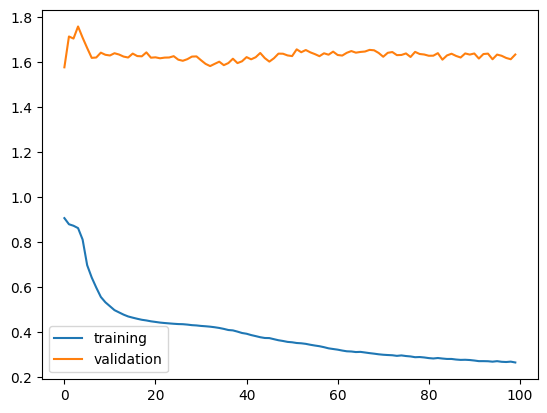

In [ ]:
plt.plot(range(len(model_mang.history['loss'])), model_mang.history['loss'], label = 'training')
plt.plot(range(len(model_mang.history['val_loss'])), model_mang.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

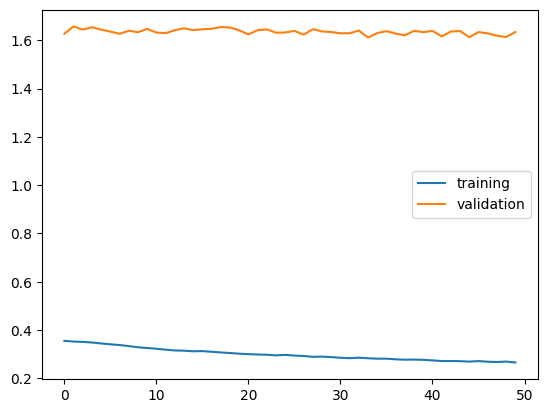

In [ ]:
plt.plot(range(len(model_mang.history['loss'][50:])), model_mang.history['loss'][50:], label = 'training')
plt.plot(range(len(model_mang.history['val_loss'][50:])), model_mang.history['val_loss'][50:], label = 'validation')
plt.legend()
plt.show()

In [ ]:
tma_test.head()

tanggal  Katulampa  Depok  Manggarai        KBR2         KBR4
3672 2023-01-01 00:00:00       29.0  118.0      669.0  860.681681  1006.353364
3673 2023-01-01 01:00:00       35.0  133.0      700.0  866.996937  1006.397310
3674 2023-01-01 02:00:00       35.0  131.0      704.0  870.767050  1006.895161
3675 2023-01-01 03:00:00       36.0  128.0      705.0  873.458741  1006.746029
3676 2023-01-01 04:00:00       32.0  127.0      707.0  876.001144  1006.904927

In [ ]:
# Prediction
test_scaled = scaler.transform(tma_test[['Katulampa', 'Depok', 'KBR2', 'KBR4', 'Manggarai']])

array_katulampa = array(test_scaled[:, 0])
array_depok = array(test_scaled[:, 1])
array_kbr2 = array(test_scaled[:, 2])
array_kbr4 = array(test_scaled[:, 3])
# array_bdr5 = array(test_scaled[:, 4])
array_manggarai = array(test_scaled[:, 4])

# convert to [rows, columns] structure
array_katulampa = array_katulampa.reshape((len(array_katulampa), 1))
array_depok = array_depok.reshape((len(array_depok), 1))
array_kbr2 = array_kbr2.reshape((len(array_kbr2), 1))
array_kbr4 = array_kbr4.reshape((len(array_kbr4), 1))
# array_bdr5 = array_bdr5.reshape((len(array_bdr5), 1))
array_manggarai = array_manggarai.reshape((len(array_manggarai), 1))

# test_input = hstack((array_katulampa, array_depok, array_kbr2, array_kbr4, array_bdr5, array_manggarai))
test_input = hstack((array_katulampa, array_depok, array_kbr2, array_kbr4, array_manggarai))
x_test, y_test = split_sequences(test_input, n_steps_in, n_steps_out)
# print(x_input)

# x_input = x_input.reshape((1, n_steps_in, n_features))
y_pred = model.predict(x_test, verbose = 0)


In [ ]:
print(len(X), len(y), len(x_test), len(y_test), len(y_pred))

3499 3499 1892 1892 1892


In [ ]:
print(y_pred)
# y_pred = scaler.inverse_transform(squeeze(y_pred))
# print(y_pred)

[[[-0.5498907  -0.22880039 -0.7354814   0.5165521  -0.65470064]
  [-0.6435752  -0.22349352 -0.83065546  0.5355375  -0.63431716]
  [-0.65376574 -0.21679313 -0.82181287  0.53532106 -0.6129028 ]
  [-0.64271563 -0.20494078 -0.8375025   0.5396645  -0.63278437]
  [-0.6271839  -0.17912802 -0.8458808   0.5452797  -0.64753807]
  [-0.61220247 -0.14844921 -0.8512356   0.5509853  -0.65253186]]

 [[-0.5568503  -0.22475864 -0.7423992   0.5179218  -0.6502053 ]
  [-0.6466184  -0.22318277 -0.8400739   0.53661025 -0.6281662 ]
  [-0.6542847  -0.21989101 -0.8321905   0.5358081  -0.60488397]
  [-0.6431334  -0.21059735 -0.85029674  0.54039544 -0.6241005 ]
  [-0.6296151  -0.18522862 -0.8585027   0.5465236  -0.63854367]
  [-0.6169947  -0.15403037 -0.8626229   0.5528292  -0.643846  ]]

 [[-0.5611007  -0.22252306 -0.7474164   0.5185865  -0.6493545 ]
  [-0.64769685 -0.22329354 -0.84555507  0.5369868  -0.62645525]
  [-0.6534987  -0.22188345 -0.8374292   0.53570515 -0.6015793 ]
  [-0.64210457 -0.21403587 -0.856933

In [ ]:
scaler.inverse_transform(y_test[0])

array([[  22.        ,  108.        ,  807.33185758, 1135.35598327,
         623.        ],
       [  22.        ,  108.        ,  808.25326345, 1134.94114132,
         622.        ],
       [  20.        ,  110.        ,  807.44774985, 1135.21092083,
         620.        ],
       [  20.        ,  109.        ,  806.47475324, 1135.13218428,
         620.        ],
       [  21.        ,  107.        ,  807.03776537, 1135.4839556 ,
         619.        ],
       [  21.        ,  106.        ,  807.31565759, 1135.5067424 ,
         619.        ]])

In [ ]:
len(x_test[0])

168

In [ ]:
x_test[0]

array([[ 1.93170633e-01,  2.35737427e-01, -1.05885180e-01,
        -2.02007458e+00,  6.71783693e-01],
       [ 6.96712443e-01,  8.67336682e-01, -2.20171345e-03,
        -2.01921045e+00,  1.40227242e+00],
       [ 6.96712443e-01,  7.83123448e-01,  5.96957486e-02,
        -2.00942099e+00,  1.49652902e+00],
       [ 7.80636078e-01,  6.56803597e-01,  1.03887762e-01,
        -2.01235342e+00,  1.52009318e+00],
       [ 4.44941538e-01,  6.14696980e-01,  1.45628756e-01,
        -2.00922896e+00,  1.56722148e+00],
       [ 4.44941538e-01,  5.30483746e-01,  1.43754687e-01,
        -2.01239743e+00,  1.59078563e+00],
       [ 4.44941538e-01,  5.30483746e-01,  7.08951506e-02,
        -2.13957251e+00,  1.56722148e+00],
       [ 1.61987243e+00,  8.67336682e-01, -6.45288201e-02,
        -2.13468778e+00,  1.42583657e+00],
       [ 2.45910878e+00,  6.98910214e-01, -2.28968121e-01,
        -2.10279899e+00,  1.49652902e+00],
       [ 2.79480332e+00,  7.83123448e-01, -2.87358865e-01,
        -2.07677109e+00

In [ ]:
print(len(y_pred[0]), n_steps_out)

6 6


In [ ]:
y_pred[0][0][0]

-0.46410686

In [ ]:
len(y_test[0])

6

In [ ]:
y_test_scale_inv = []
y_pred_scale_inv = []
for i in range(len(y_test)):
  y_test_scale_inv.append(scaler.inverse_transform(y_test[i]))
  y_pred_scale_inv.append(scaler.inverse_transform(y_pred[i]))

In [ ]:
y_pred_scale_inv = squeeze(y_pred_scale_inv)
y_pred_scale_inv

array([[[  21.168148,  107.006035,  824.7943  , 1136.0137  ,
          612.40247 ],
        [  20.087662,  108.25244 ,  822.79846 , 1135.2874  ,
          615.02106 ],
        [  19.682383,  109.024506,  821.0805  , 1134.455   ,
          615.65594 ],
        [  18.987345,  108.748665,  818.3929  , 1134.1346  ,
          616.7651  ],
        [  18.539934,  108.2962  ,  817.19006 , 1134.0114  ,
          619.7147  ],
        [  18.487494,  108.102684,  816.5373  , 1134.0438  ,
          623.0898  ]],

       [[  21.132675,  107.04263 ,  824.3286  , 1136.0352  ,
          612.25574 ],
        [  20.042864,  108.30087 ,  822.20685 , 1135.3348  ,
          614.9619  ],
        [  19.644905,  109.066216,  820.3766  , 1134.5037  ,
          615.68097 ],
        [  18.955025,  108.75756 ,  817.55927 , 1134.1892  ,
          616.864   ],
        [  18.519398,  108.25726 ,  816.19403 , 1134.0833  ,
          619.8604  ],
        [  18.500458,  108.01357 ,  815.5271  , 1134.1256  ,
          623

In [ ]:
y_pred_scale_inv[0][1]

array([  20.087662,  108.25244 ,  822.79846 , 1135.2874  ,  615.02106 ],
      dtype=float32)

Katulampa RMSE: 7.861 cm


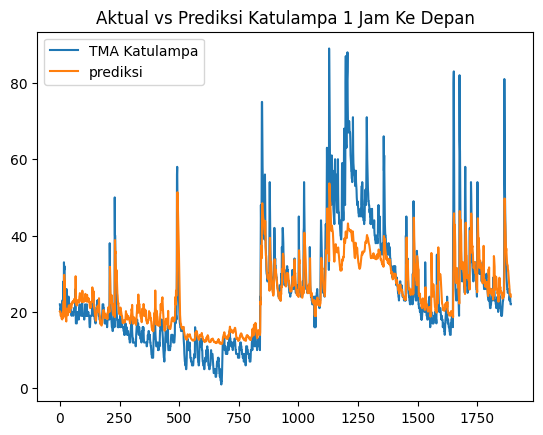

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
# for i in range(1500,1800):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

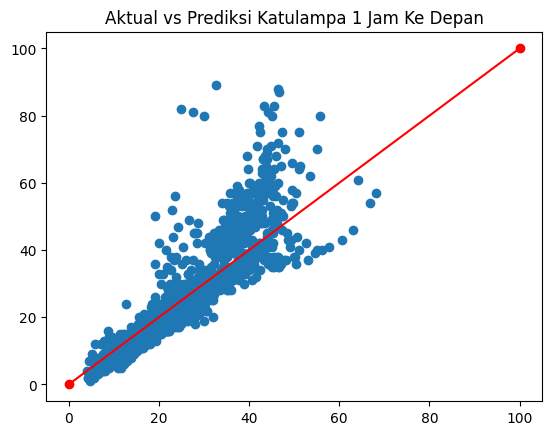

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Katulampa RMSE: 7.763 cm


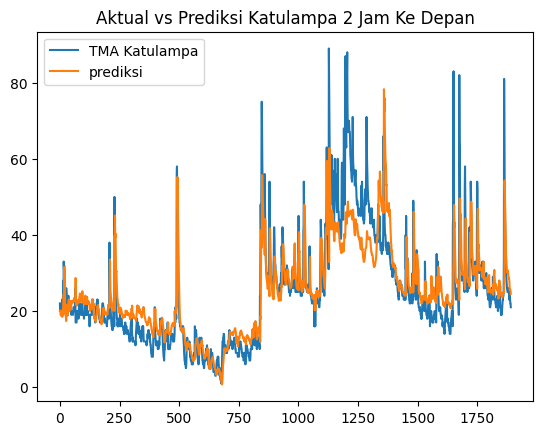

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

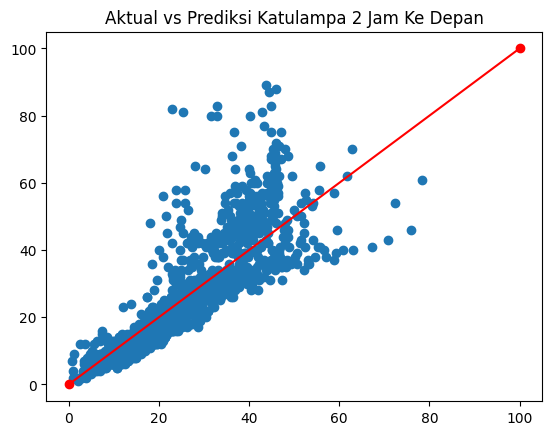

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Katulampa RMSE: 8.407 cm


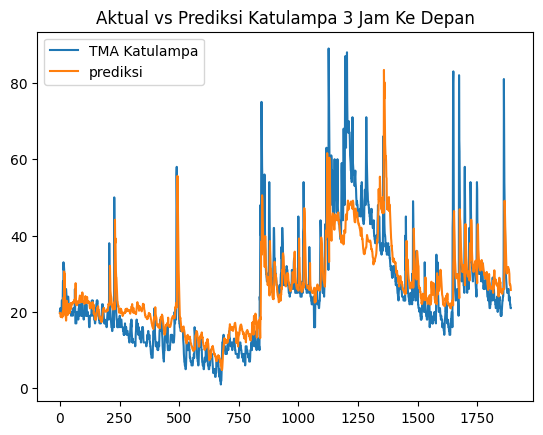

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

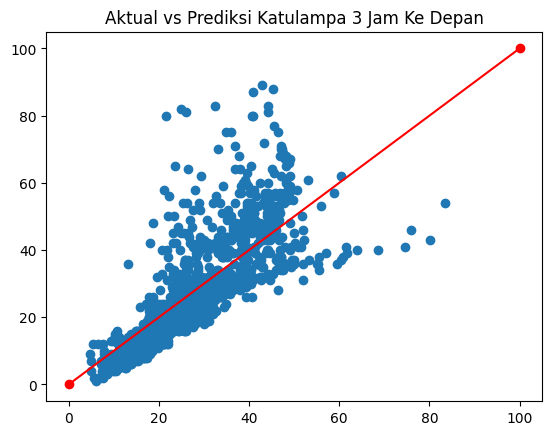

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Katulampa RMSE: 9.096 cm


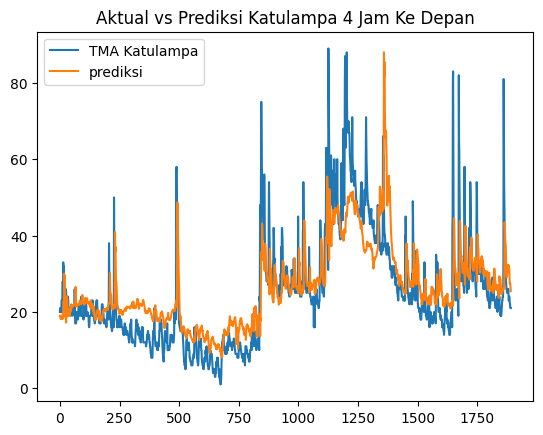

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

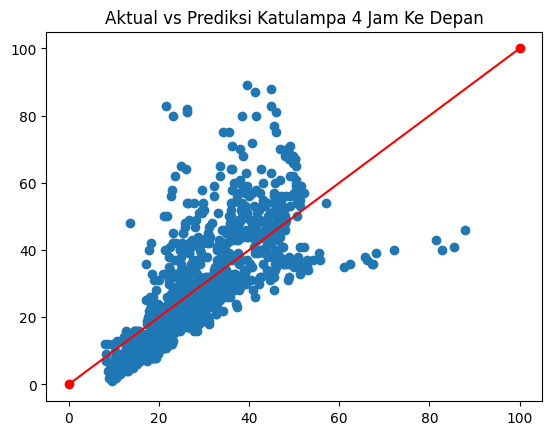

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Katulampa RMSE: 9.686 cm


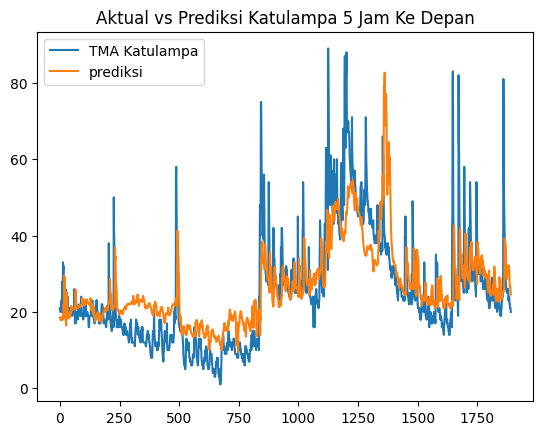

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

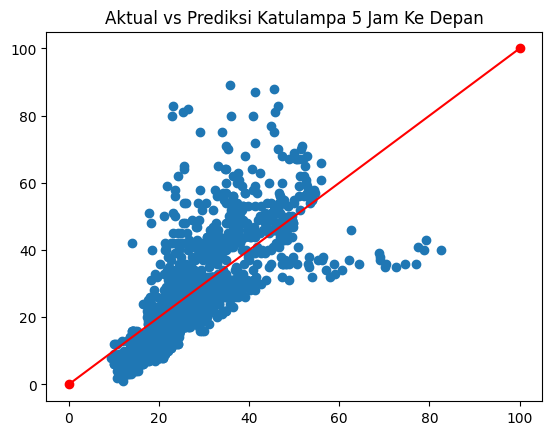

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Katulampa RMSE: 10.181 cm


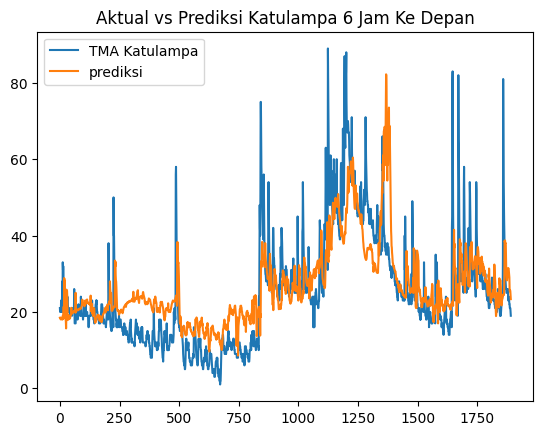

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

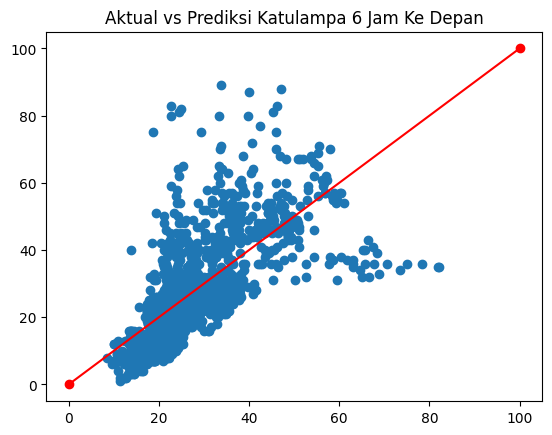

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Depok RMSE: 14.180 cm


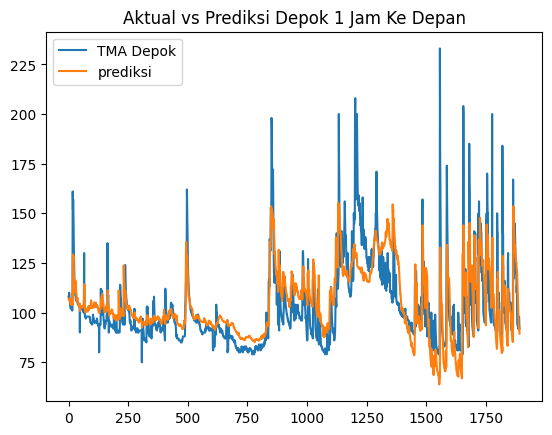

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

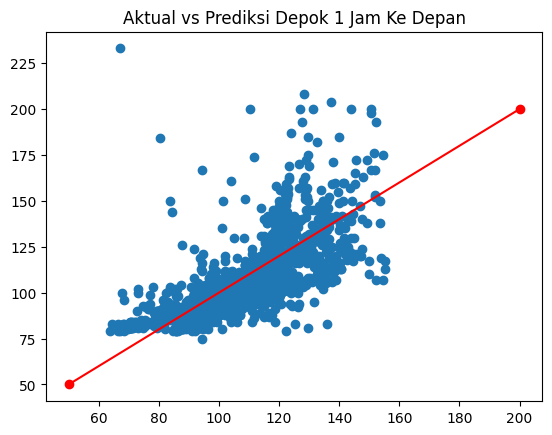

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Depok RMSE: 16.698 cm


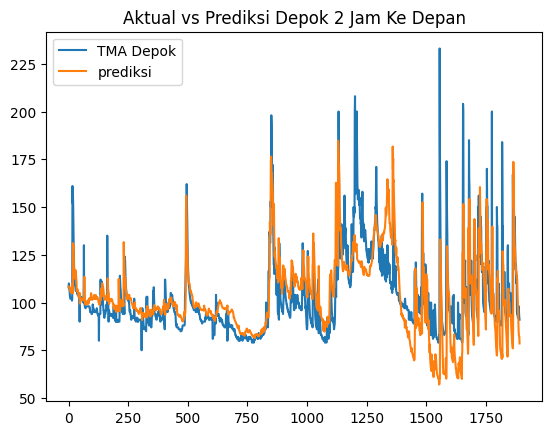

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

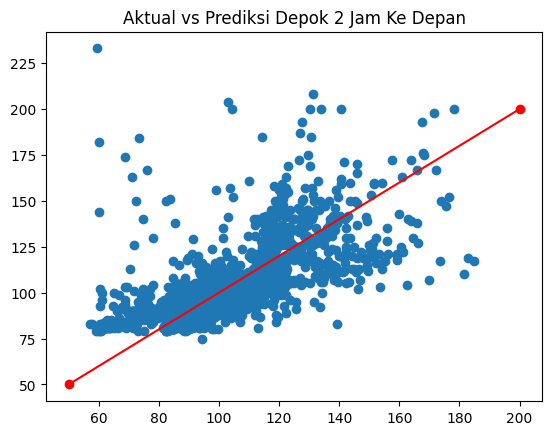

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Depok RMSE: 18.405 cm


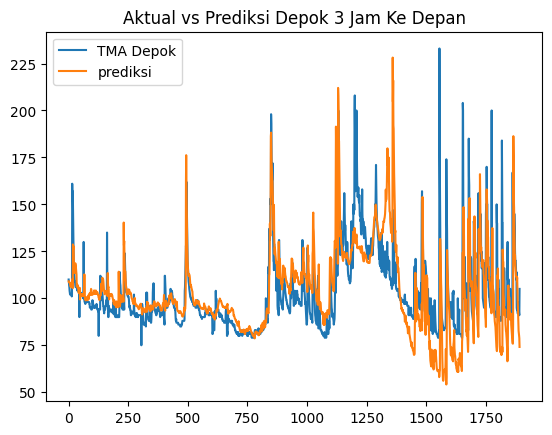

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

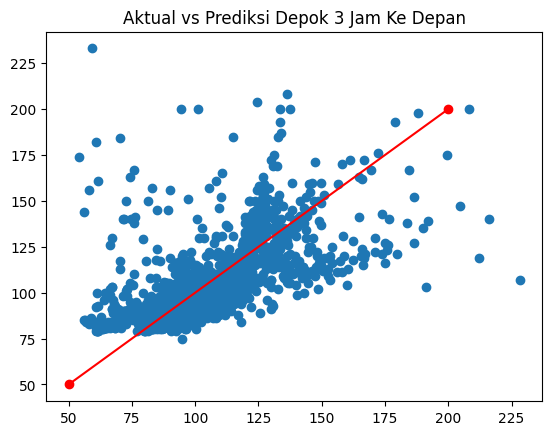

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Depok RMSE: 19.726 cm


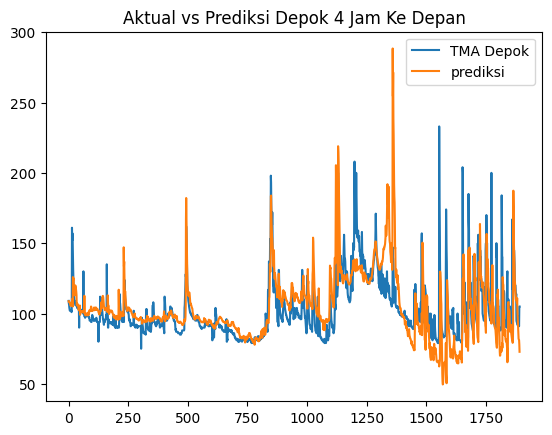

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSEm: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

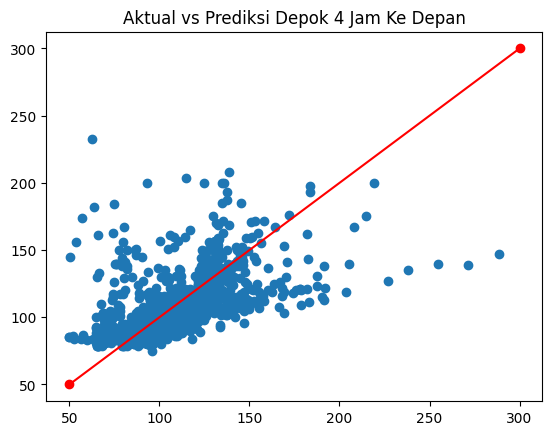

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 300
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Depok RMSE: 21.380 cm


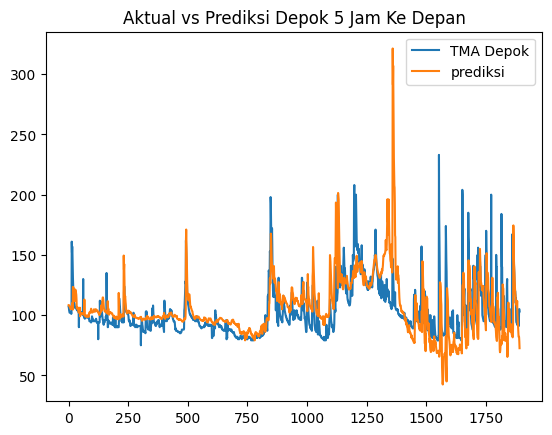

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

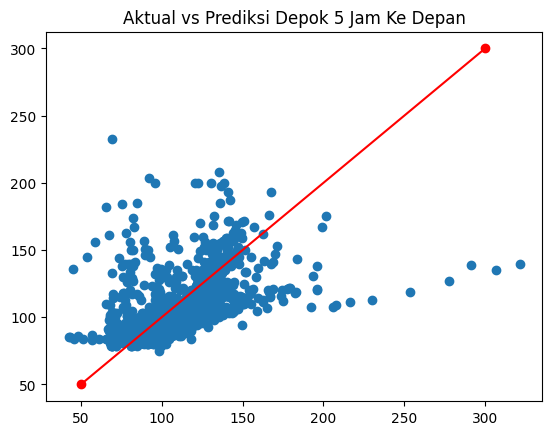

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 300
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Depok RMSE: 22.699 cm


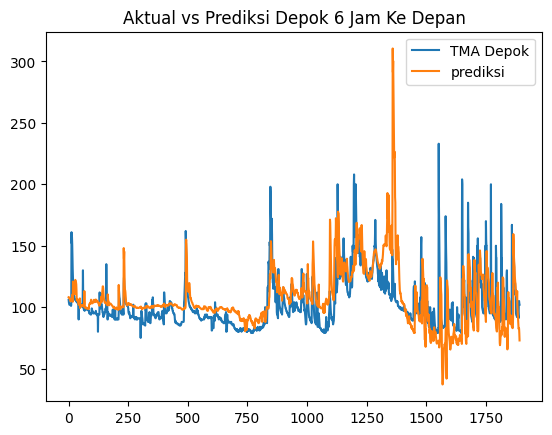

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

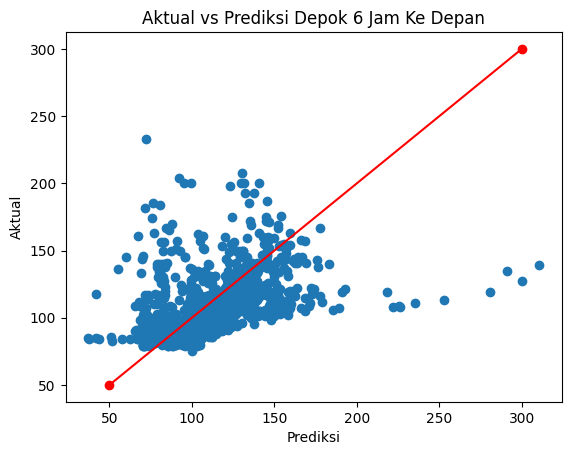

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 300
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR2 RMSE: 19.499 cm


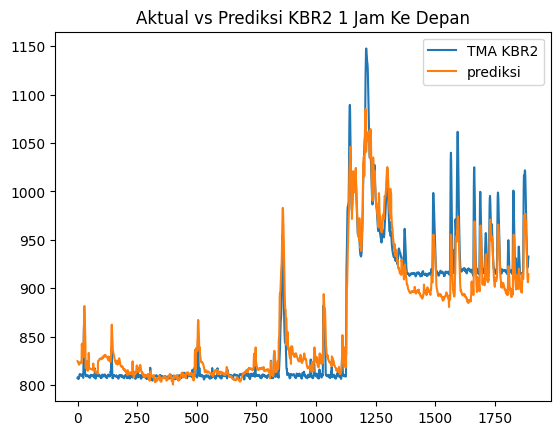

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

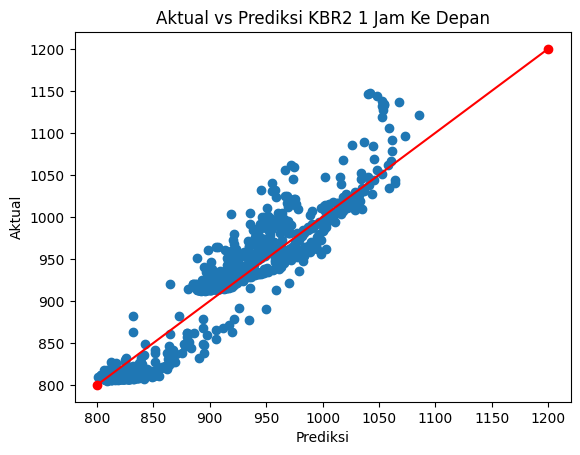

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR2 RMSE: 20.782 cm


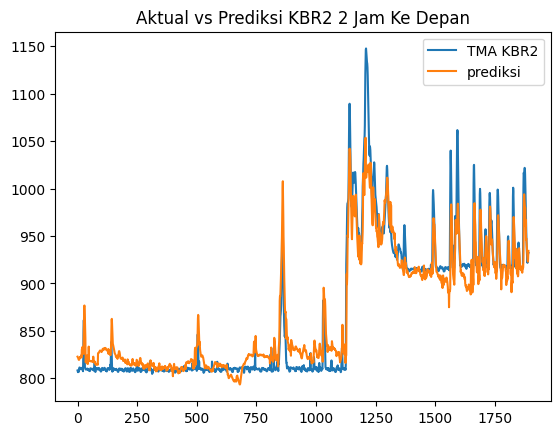

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

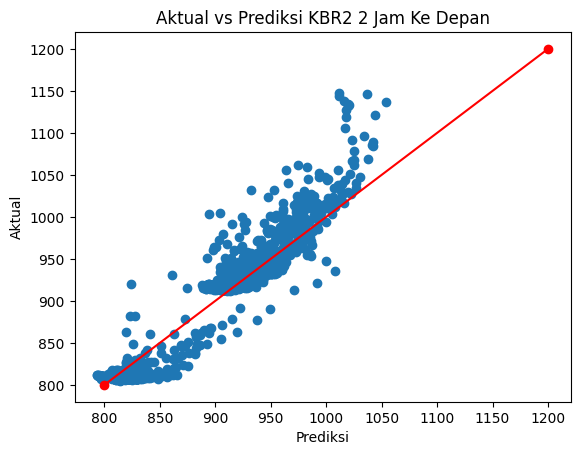

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR2 RMSE: 26.811 cm


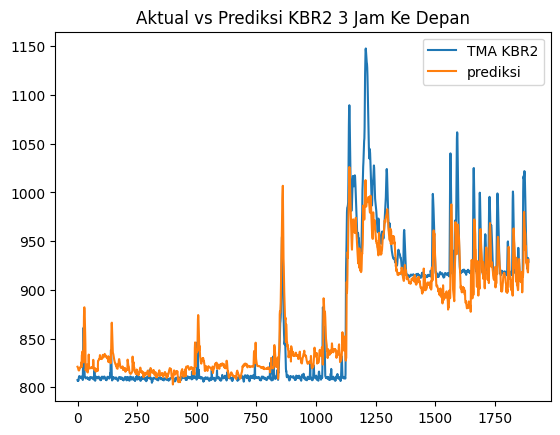

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

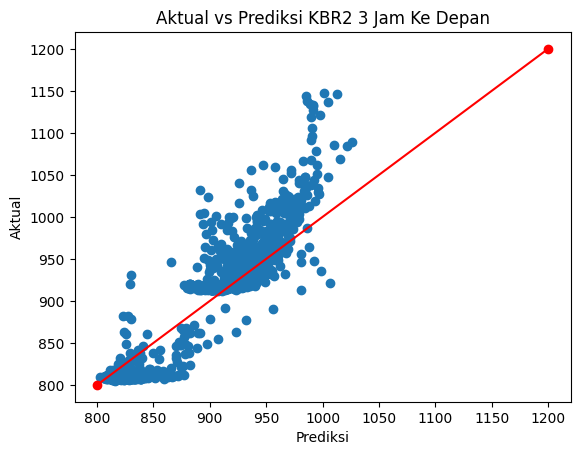

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR2 RMSE: 31.568 cm


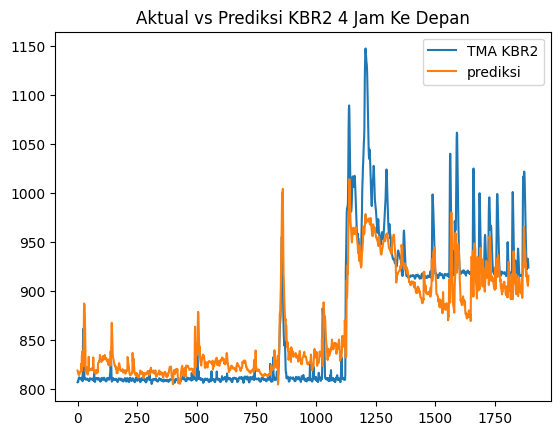

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

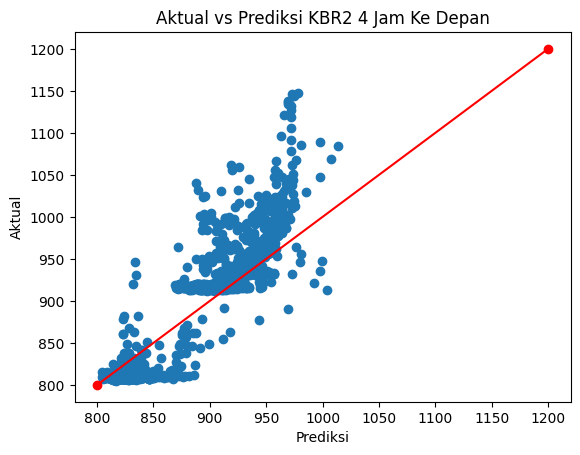

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR2 RMSE: 35.493 cm


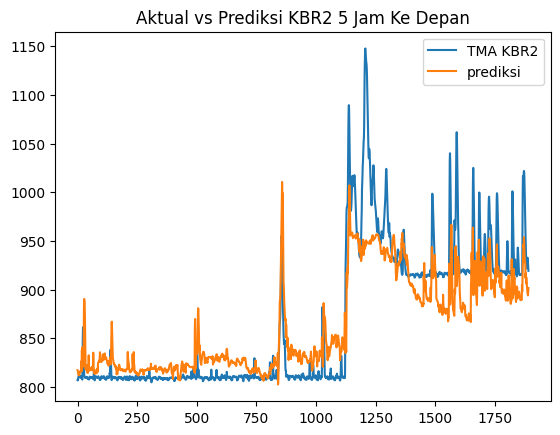

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

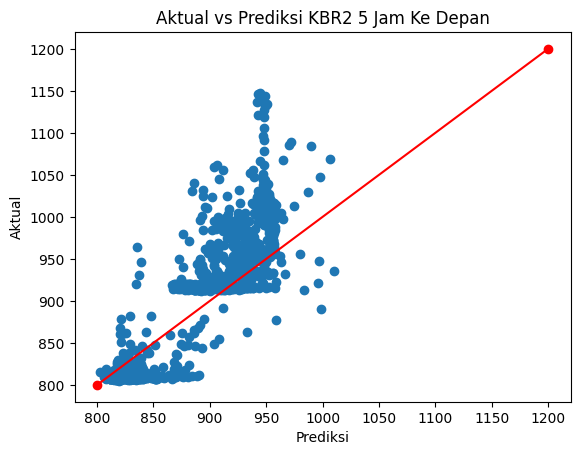

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR2 RMSE: 39.222 cm


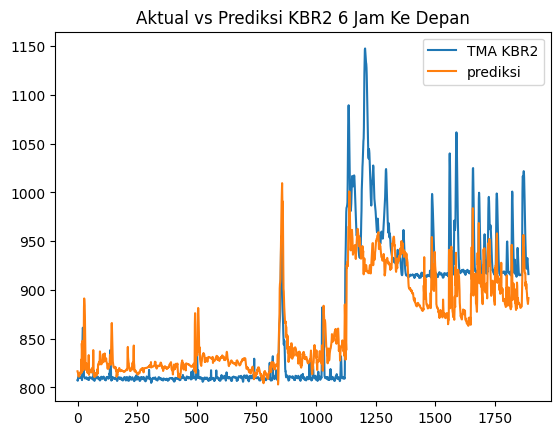

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

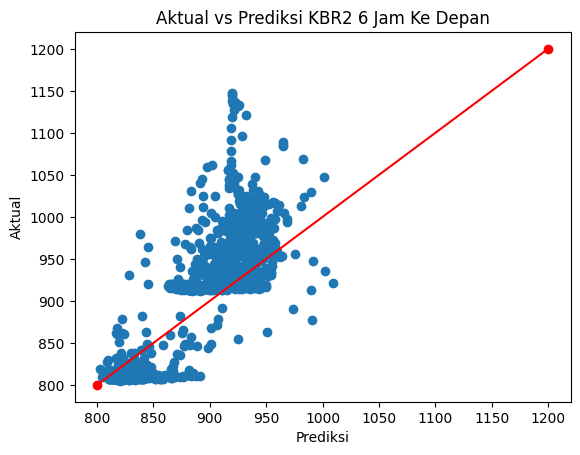

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR4 RMSE: 11.535 cm


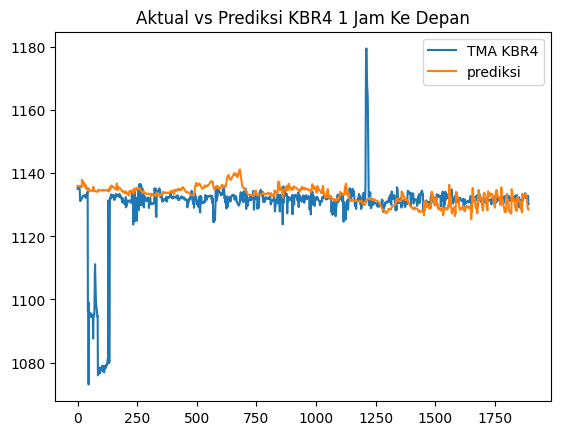

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

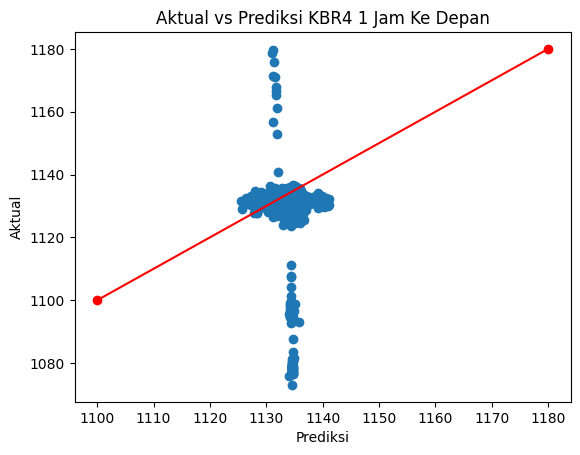

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR4 RMSE: 11.481 cm


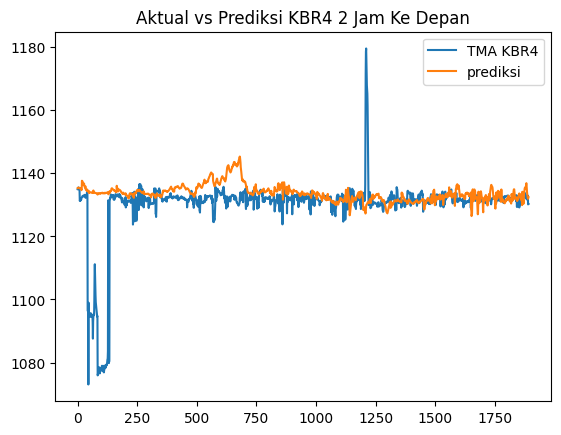

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

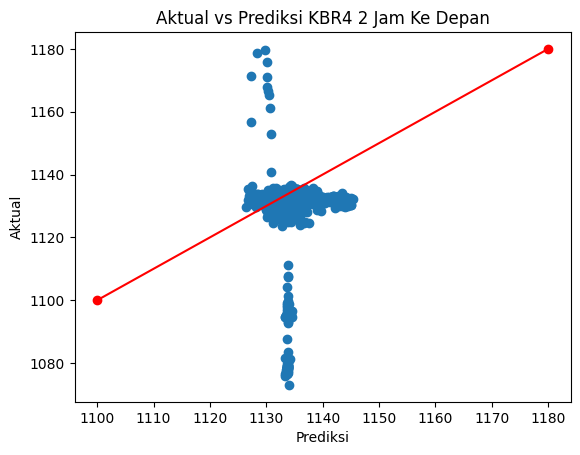

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR4 RMSE: 11.153 cm


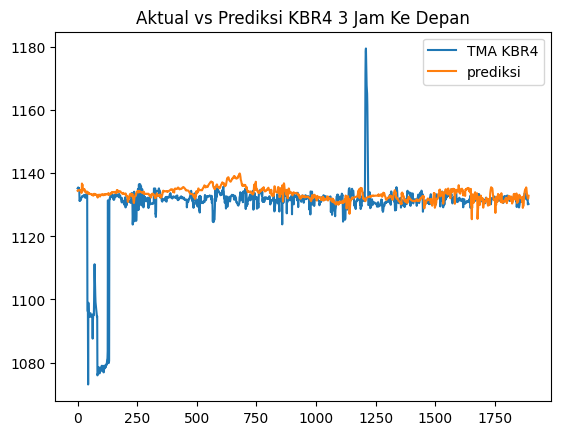

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

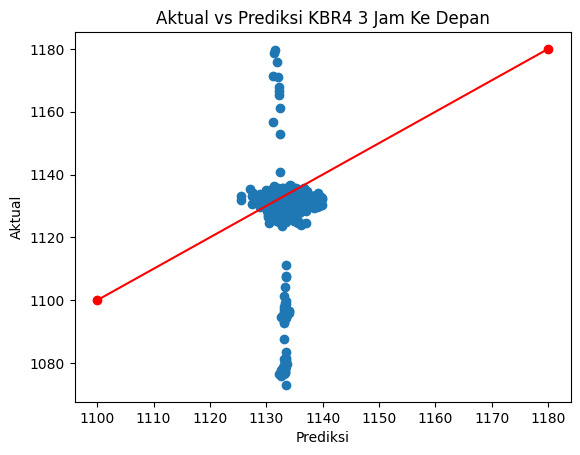

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR4 RMSE: 11.010 cm


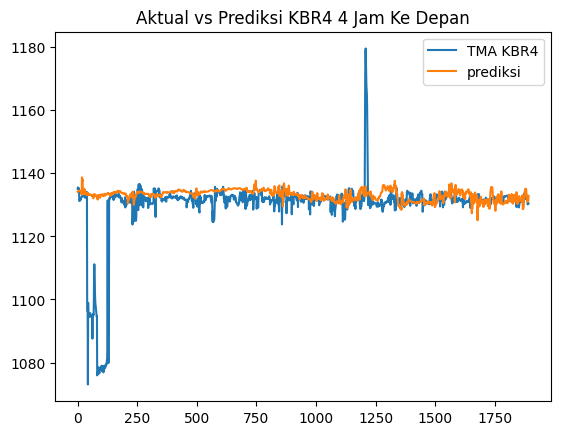

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

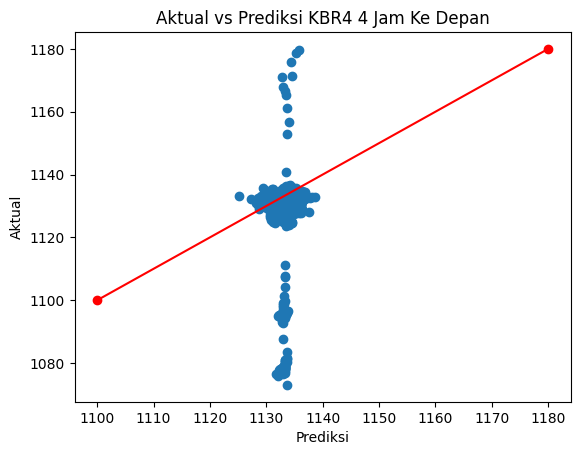

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR4 RMSE: 10.996 cm


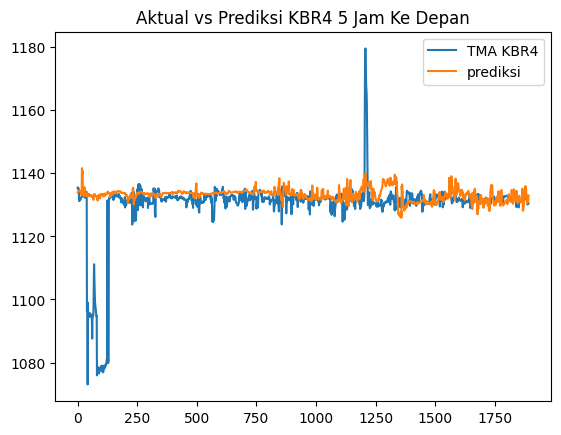

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

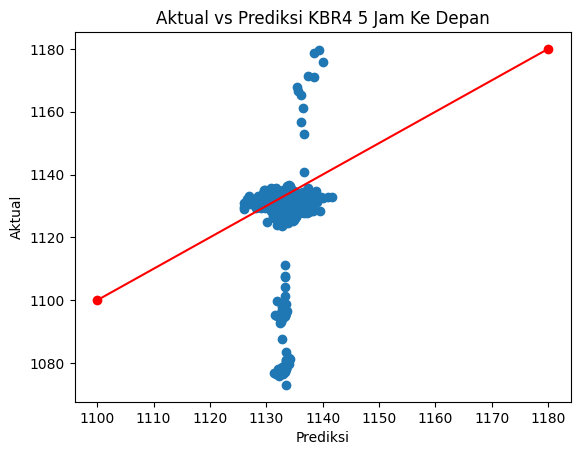

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

KBR4 RMSE: 11.081 cm


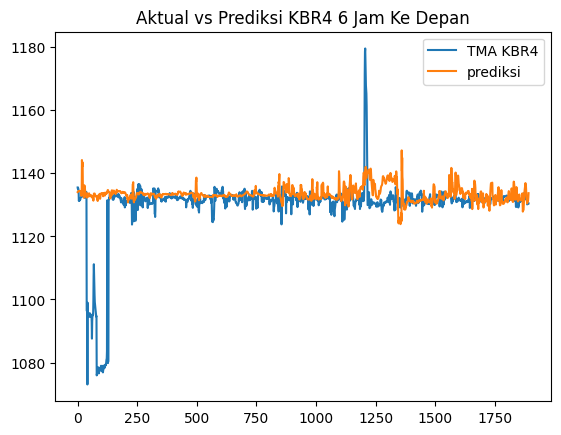

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

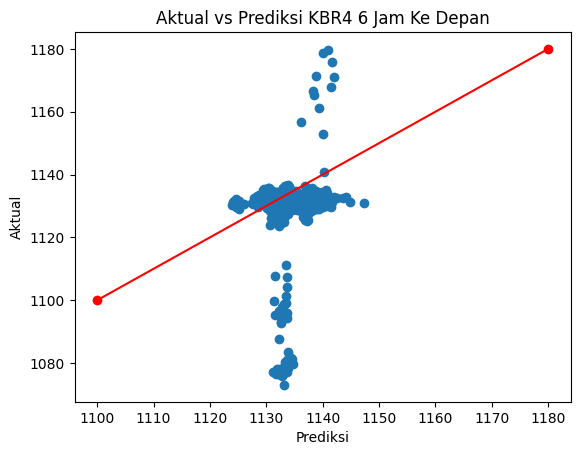

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

Manggarai RMSE: 21.927 cm


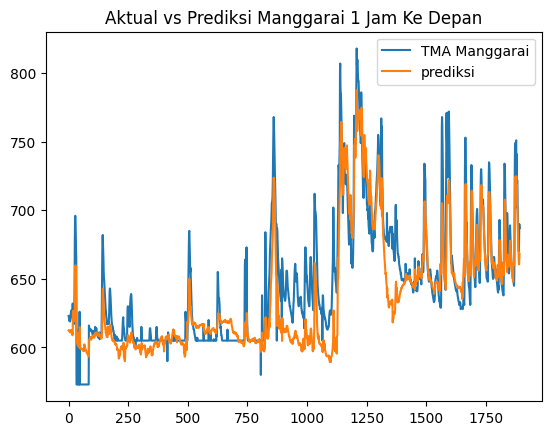

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

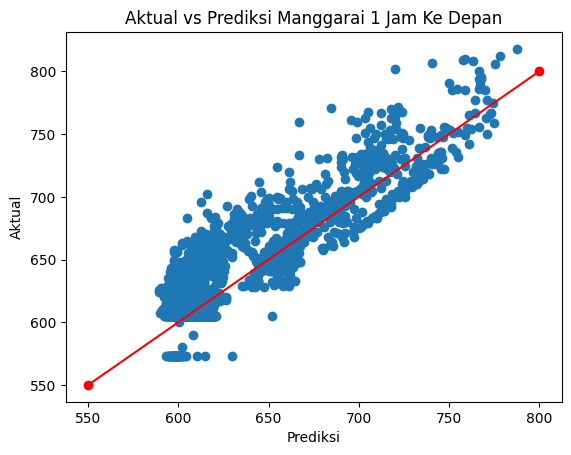

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

Manggarai RMSE: 23.668 cm


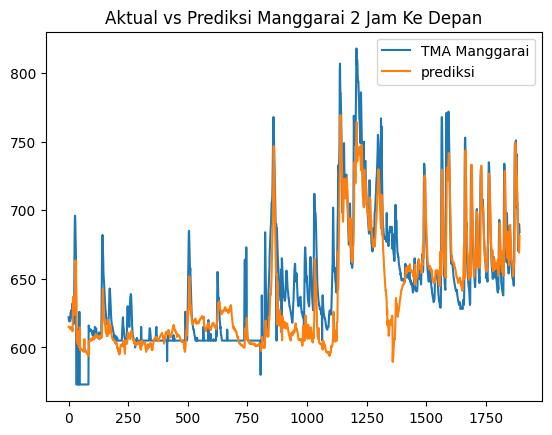

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

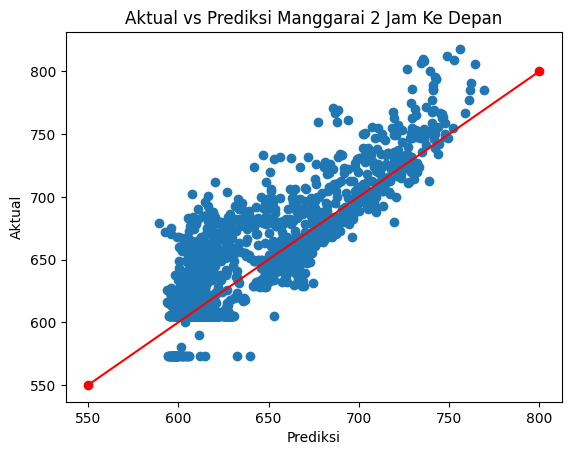

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

Manggarai RMSE: 26.683 cm


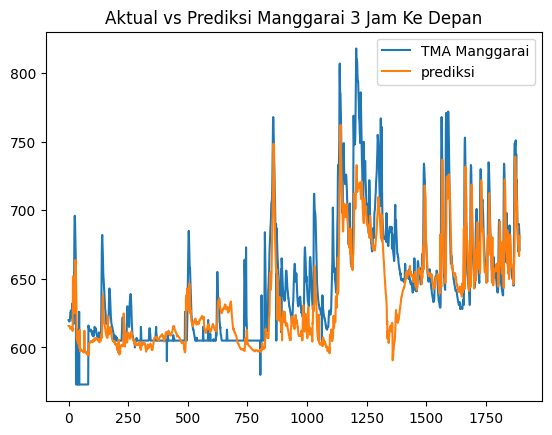

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

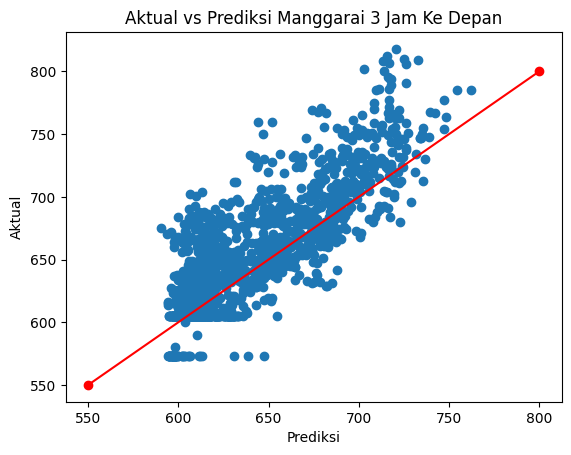

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

Manggarai RMSE: 28.625 cm


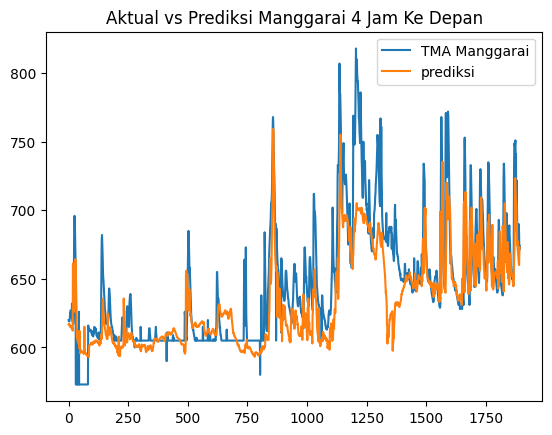

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

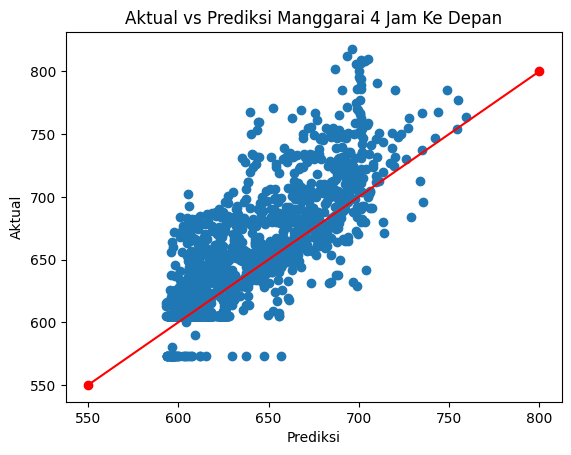

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

Manggarai RMSE: 30.488 cm


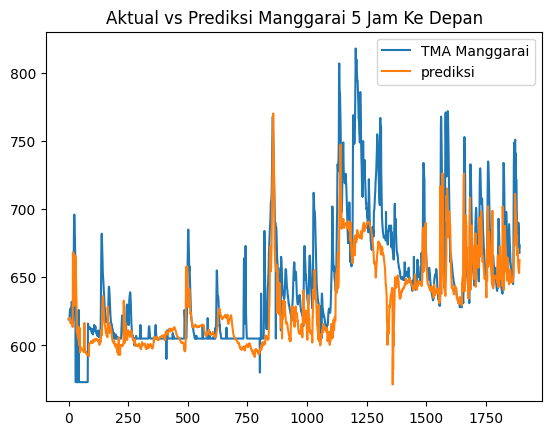

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

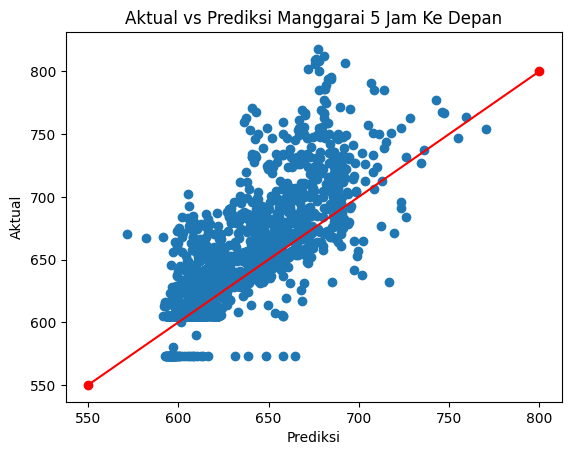

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

Manggarai RMSE: 32.798 cm


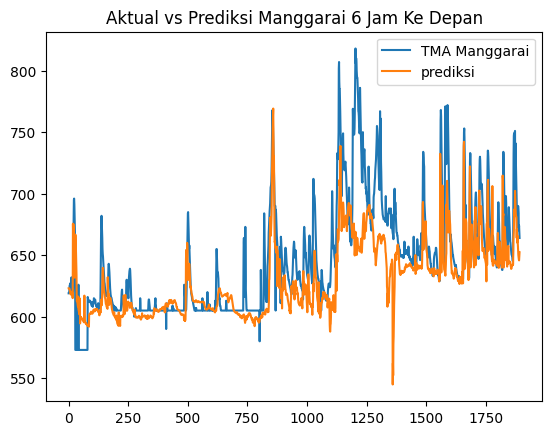

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi}")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

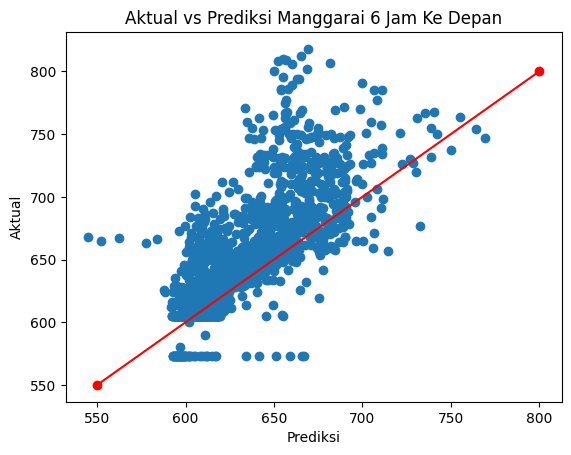

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
import seaborn as sns

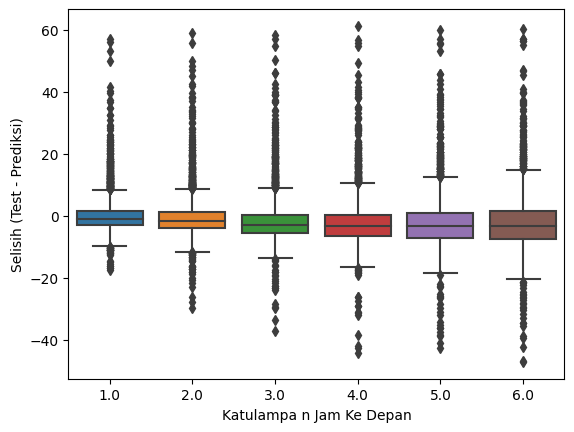

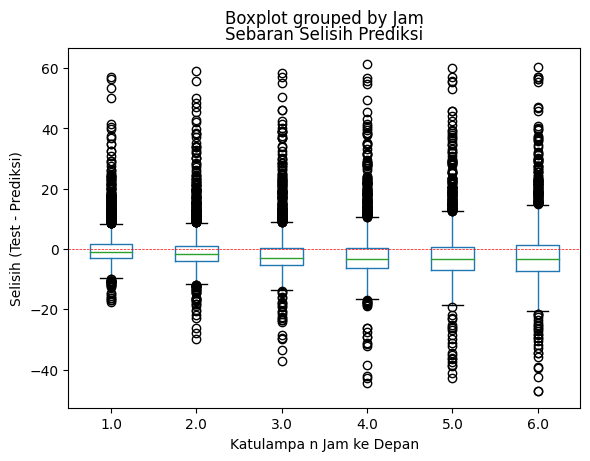

In [ ]:
x = 0
lokasi = 'Katulampa'
list_test = []
list_pred = []
list_diff = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])

data = pd.DataFrame([jam, list_test, list_pred, list_diff])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

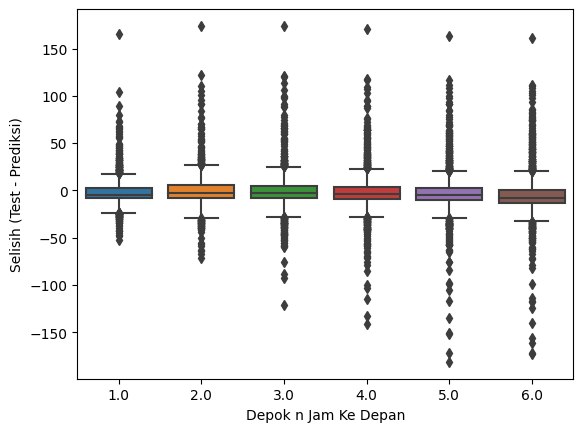

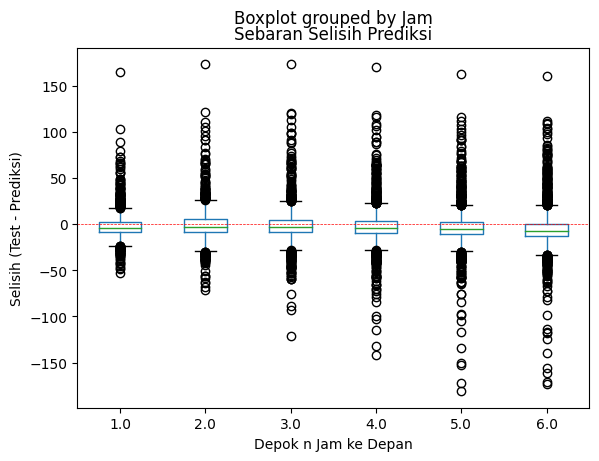

In [ ]:
x = 1
lokasi = 'Depok'
list_test = []
list_pred = []
list_diff = []
list_diff_squared = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])
    list_diff_squared.append((y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])**2)

data = pd.DataFrame([jam, list_test, list_pred, list_diff, list_diff_squared])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff", "Diff_Squared"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

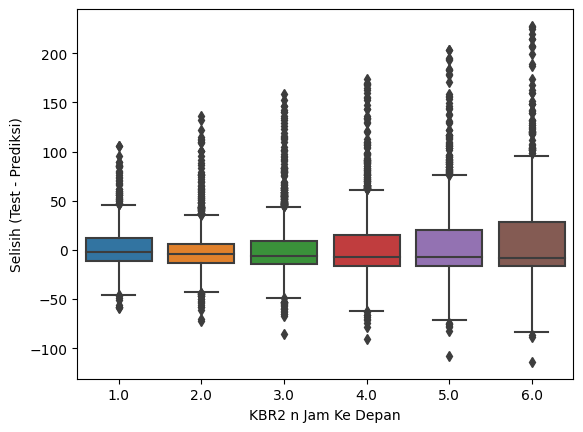

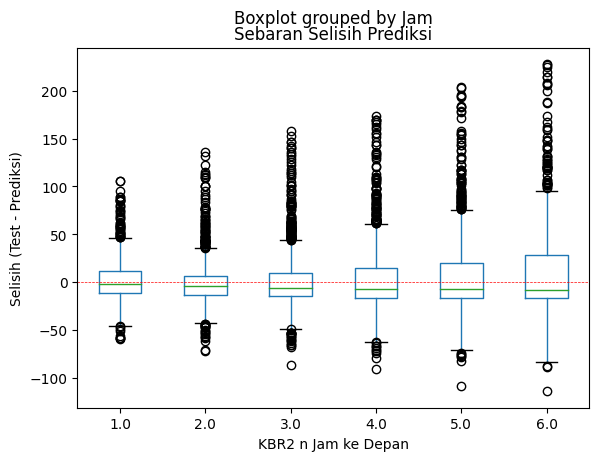

In [ ]:
x = 2
lokasi = 'KBR2'
list_test = []
list_pred = []
list_diff = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])

data = pd.DataFrame([jam, list_test, list_pred, list_diff])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

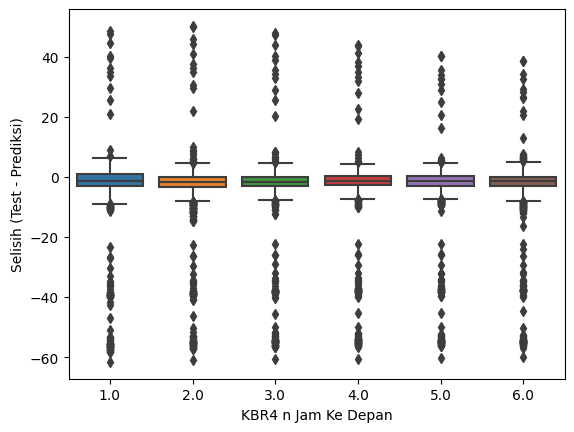

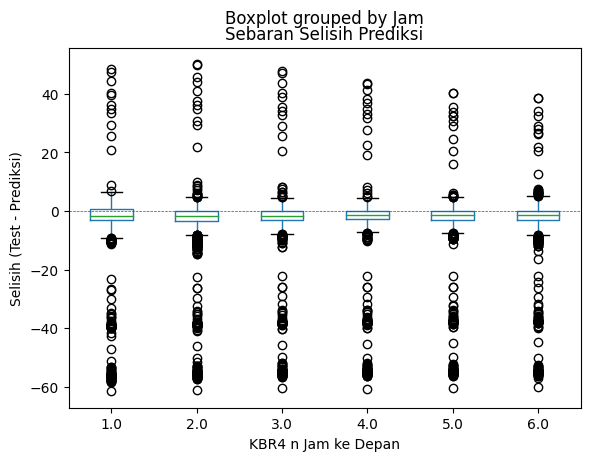

In [ ]:
x = 3
lokasi = 'KBR4'
list_test = []
list_pred = []
list_diff = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])

data = pd.DataFrame([jam, list_test, list_pred, list_diff])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

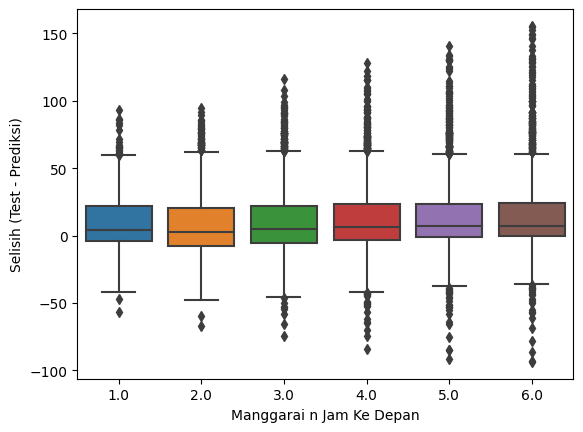

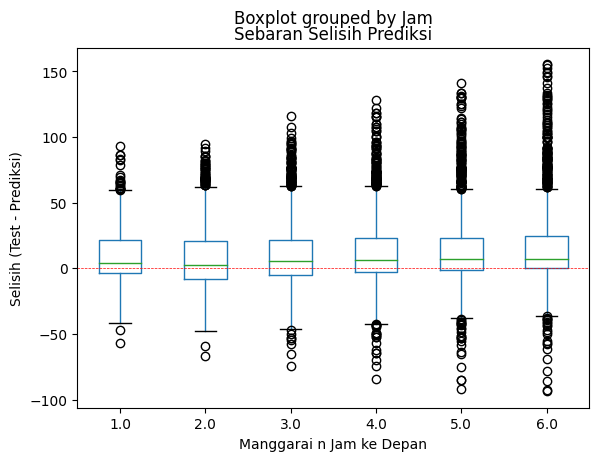

In [ ]:
x = 4
lokasi = 'Manggarai'
list_test = []
list_pred = []
list_diff = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])

data = pd.DataFrame([jam, list_test, list_pred, list_diff])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

In [ ]:
import pickle
pickle.dump(model, open('drive/Shareddrives/JSC Pengendalian Banjir DKI/ciliwung_manggarai_multivariate_multistep_lstm_7hari_5lokasi_0.6.5.sav', 'wb'))

In [ ]:
model.save("drive/Shareddrives/JSC Pengendalian Banjir DKI/ciliwung_manggarai_multivariate_multistep_lstm_7hari_5lokasi_0.6.5")